In [164]:
import torch
import torch.nn as nn
from setuptools.command.rotate import rotate
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torchmetrics import Accuracy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
from torch.nn.utils.rnn import pad_sequence
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/abhishekwaghchaure/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhishekwaghchaure/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abhishekwaghchaure/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Approach Without making Custom Dataset 

In [139]:
historic_data = pd.read_csv('/Users/abhishekwaghchaure/Desktop/My_practice_noteooks/Torch/NLP/Sentiment Analysis/a1_RestaurantReviews_HistoricDump.tsv', sep='\t')

fresh_data = pd.read_csv('/Users/abhishekwaghchaure/Desktop/My_practice_noteooks/Torch/NLP/Sentiment Analysis/a2_RestaurantReviews_FreshDump.tsv', sep='\t')

In [140]:
historic_data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [141]:
fresh_data.head()

,Review
0,Spend your money elsewhere.
1,Their regular toasted bread was equally satisf...
2,The Buffet at Bellagio was far from what I ant...
3,"And the drinks are WEAK, people!"
4,-My order was not correct.


In [142]:
print(f"Historic data shape : {historic_data.shape}")
print(f"Fresh Data shape : {fresh_data.shape}")

Historic data shape : (900, 2)
Fresh Data shape : (100, 1)


In [143]:
print(historic_data['Liked'].value_counts())
print(historic_data['Liked'].unique())

Liked
1    496
0    404
Name: count, dtype: int64
[1 0]


In [144]:
label_map = {0:' Negative',
             1: 'Positive'}
liked_distribution = historic_data['Liked'].value_counts()


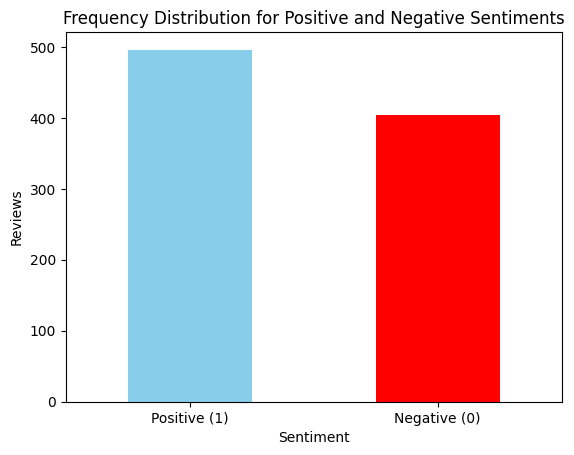

In [145]:
liked_distribution.plot(kind = 'bar', color = ['skyblue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Reviews')
plt.title('Frequency Distribution for Positive and Negative Sentiments')
plt.xticks(ticks=[0, 1], labels=['Positive (1)', 'Negative (0)'], rotation=0)
plt.show()

In [146]:
historic_review_data = historic_data['Review']
print(historic_review_data)

0                               Wow... Loved this place.
1                                     Crust is not good.
2              Not tasty and the texture was just nasty.
3      Stopped by during the late May bank holiday of...
4      The selection on the menu was great and so wer...
                             ...                        
895    I want to first say our server was great and w...
896                       The pizza selections are good.
897                I had strawberry tea, which was good.
898    Highly unprofessional and rude to a loyal patron!
899                         Overall, a great experience.
Name: Review, Length: 900, dtype: object


## Preprocessing The Text Function 

In [147]:
# Assuming `historic_review_data` is a pandas Series containing individual reviews
def text_preprocessing(data):
    lemmatizer = WordNetLemmatizer()
    corpus = []
       
    for sentence in data:
        cleaned_sentence = re.sub("[^a-zA-Z]", " ", sentence)
        cleaned_sentence = cleaned_sentence.lower()
            
        words = nltk.word_tokenize(cleaned_sentence)
            
        stemmed_words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words("english")]
            
        final_sentence = " ".join(stemmed_words)
        corpus.append(final_sentence)
    
    return corpus

# Call the function and print the results
processed_data = text_preprocessing(historic_review_data)
print(processed_data)

['wow loved place', 'crust good', 'tasty texture nasty', 'stopped late may bank holiday rick steve recommendation loved', 'selection menu great price', 'getting angry want damn pho', 'honeslty taste fresh', 'potato like rubber could tell made ahead time kept warmer', 'fry great', 'great touch', 'service prompt', 'would go back', 'cashier care ever say still ended wayyy overpriced', 'tried cape cod ravoli chicken cranberry mmmm', 'disgusted pretty sure human hair', 'shocked sign indicate cash', 'highly recommended', 'waitress little slow service', 'place worth time let alone vega', 'like', 'burrittos blah', 'food amazing', 'service also cute', 'could care less interior beautiful', 'performed', 'right red velvet cake ohhh stuff good', 'never brought salad asked', 'hole wall great mexican street taco friendly staff', 'took hour get food table restaurant food luke warm sever running around like totally overwhelmed', 'worst salmon sashimi', 'also combo like burger fry beer decent deal', 'li

## Creating Vocabulary and Indexing 

In [175]:
def word_to_idx_vocab(preprocessed_data):
    all_words = [word for sentence in preprocessed_data for word in nltk.word_tokenize(sentence)]
    word_to_idx = {word : idx for idx,word in enumerate(set(all_words))}
    word_to_idx['<PAD>'] = 0
    
    indexed_historic_data = [[word_to_idx[word] for word in nltk.word_tokenize(sent)] for sent in processed_data]
    indexed_historic_data_padded = pad_sequence(
        [torch.tensor(seq) for seq in indexed_historic_data], 
        batch_first=True, 
        padding_value=0
    )
    return {
        'all_words': all_words,
        'word_to_idx': word_to_idx,
        'indexed_historic_padded' : indexed_historic_data_padded
    }

In [176]:
result = word_to_idx_vocab(processed_data)

In [177]:
result['indexed_historic_padded'].shape

torch.Size([900, 19])

## Embedding

Just checking how embedding will work with num_dimension = 10, num_embeddings = len(vocab)
It will be automatically taken care of in the model

In [182]:
num_dim = 10
embedding = nn.Embedding(num_embeddings= len(result['all_words']), embedding_dim = num_dim)
embedded_historic_data = []
for sent in result['indexed_historic_padded']:
    sent = torch.tensor(sent,dtype=torch.long)
    output = embedding(sent) 
    embedded_historic_data.append(output)
    

/var/folders/vt/hgv58_ws0rjfsg_1d8fcxgww0000gn/T/ipykernel_47927/585154480.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sent = torch.tensor(sent)


In [163]:
embedded_historic_data

[tensor([[ 0.6715,  0.3985, -0.2789, -1.4158, -0.0071,  1.1056, -0.8965,  0.0037,
          -1.2299,  1.3445],
         [ 0.7076,  0.2986,  1.7673, -1.9823,  0.5500,  0.9851,  0.5874, -1.6682,
          -0.8392,  0.3621],
         [ 1.7585,  0.7467,  0.2841,  1.6363,  0.1876, -1.3611, -2.5907, -0.1969,
          -1.9561,  1.4604]], grad_fn=<EmbeddingBackward0>),
 tensor([[-1.4948,  1.3652, -0.7079,  0.1438, -0.1622, -0.3117, -1.5951, -0.1851,
          -1.4571,  0.0843],
         [ 0.1183, -2.0526,  0.4334,  1.9996, -0.4296,  0.4451,  0.9566,  0.3542,
          -1.6173, -1.3599]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.6407,  0.0114,  0.3002,  0.5641,  0.2759, -0.6470, -1.2302,  0.8564,
          -1.3756,  1.4491],
         [-0.1998,  0.0589,  1.3532, -0.3515,  0.1281,  1.5342, -0.2298,  1.2387,
          -1.4662,  0.3391],
         [-0.0471,  0.8066, -0.2060, -1.0542, -0.0974, -0.9488, -1.6670,  1.0149,
          -0.5608,  0.1388]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.158

## Model 

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers):
        super(SimpleRNN,self).__init__()
        self.input_size = input_size ## Embedding_dimension -- embedding vector size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.Sequential(
            nn.Embedding(embedding_dim = self.input_size, num_embeddings=len(result['all_words'])),
            nn.RNN(self.input_size,self.hidden_size,self.num_layers, batch_first=True)
        )